# DATA PROCEESSING

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import spacy
from deep_translator import GoogleTranslator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns

## Load NLTK stopwords and lemmatizer

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /home/apoorv/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/apoorv/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/apoorv/nltk_data...


## Load spaCy model for lemmatization

In [3]:
nlp = spacy.load("en_core_web_sm")

## Set the option to display full column width and all rows

In [4]:
pd.set_option("display.max_colwidth",None)
pd.set_option("display.max_rows",None)

# Load your ABSA dataset\

In [5]:
df = pd.read_csv("../datasets/training_dataset/Restaurant_Dataset.csv")
df.head()

,Review_ID,Sentence_ID,Text,Opinion_Target,Opinion_Category,Opinion_Polarity
0,1004293,1004293:0,"Judging from previous posts this used to be a good place, but not any longer.",place,RESTAURANT#GENERAL,negative
1,1004293,1004293:1,"We, there were four of us, arrived at noon - the place was empty - and the staff acted like we were imposing on them and they were very rude.",staff,SERVICE#GENERAL,negative
2,1004293,1004293:2,"They never brought us complimentary noodles, ignored repeated requests for sugar, and threw our dishes on the table.",NaN,SERVICE#GENERAL,negative
3,1004293,1004293:3,The food was lousy - too sweet or too salty and the portions tiny.,food,FOOD#QUALITY,negative
4,1004293,1004293:3,The food was lousy - too sweet or too salty and the portions tiny.,portions,FOOD#STYLE_OPTIONS,negative


### Load database information

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1654 entries, 0 to 1653
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Review_ID         1654 non-null   int64 
 1   Sentence_ID       1654 non-null   object
 2   Text              1654 non-null   object
 3   Opinion_Target    1277 non-null   object
 4   Opinion_Category  1654 non-null   object
 5   Opinion_Polarity  1654 non-null   object
dtypes: int64(1), object(5)
memory usage: 77.7+ KB


### Finding number of missing value

In [7]:
missing_values = df.isnull().sum()
print(missing_values)

Review_ID             0
Sentence_ID           0
Text                  0
Opinion_Target      377
Opinion_Category      0
Opinion_Polarity      0
dtype: int64


### Handling missing values of Opinion_Target Column

In [8]:
def missing_value_handler(df):
    return df['Opinion_Category'].split('#')[0].lower() if pd.isna(df['Opinion_Target']) else df['Opinion_Target']

df['Opinion_Target'] = df.apply(missing_value_handler, axis = 1)

### Checking number of missing value

In [9]:
missing_values = df.isnull().sum()
print(missing_values)

Review_ID           0
Sentence_ID         0
Text                0
Opinion_Target      0
Opinion_Category    0
Opinion_Polarity    0
dtype: int64


### Data Cleaning

In [10]:
def clean_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove special characters and punctuation
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    return text

### Tokenization

In [11]:
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

### Rejoins the tokens to form the sentence back

In [12]:
def join_tokens(tokens):
    return ' '.join(tokens)

### Remove stopwords

In [13]:
def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

### Lemmatization

In [14]:
def lemmatize_text(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return lemmatized_tokens

### Removes the word with length less than or equal to 2

In [15]:
def short_remover(tokens):
    new_tokens = [word for word in tokens if len(word) > 2 ]
    return new_tokens

## Translate text into English

In [16]:
def translate(text):
    translator = GoogleTranslator(source='auto', target='en')
    return translator.translate(text)

# text1 = "बढ़िया खाना था"
# translate(text1)

### Converting emojies into words 

In [17]:
positive_emojis = """😄😀😁😆😂🤣😊🙂😎😉😍🥰😘😋😛😝😜🤪🤩🥳🥰❤️👍👌🤟🍔🍕🍣🍰🍹🍷🍺
                    🍦🍯🥞🍟🍩🥼🎉🎊🥳🍚🍘🍥🥠🥮🍢🍡🍧🍨🍦🥧🧁🍰🎂🍮🍭🍬🍫🍿🍩🍪🌰🥜
                    🍯🍻🥂🍷🍾😀😃😄😆😅🥲\😊😇🙂😀😃😄😁😅😆😂🙂😊🤒👏"""

    
negative_emojis = """😔😞😢😭😤😠😡🤬😩😫🥺😖😣😠😤😷🤒🤕😐😶😒😏🙁🥶😨😱😰😳🥵😳😵
                     🤯🤐🤮🥴🤢👎😈👿💔😩😔😞😢😭"""


# add space between word and emoji
def handle_emoji_helper(text):
    i = 0
    lst = list(text)
    for word in text:
        if word !=" " and (word in positive_emojis or word in negative_emojis):
            lst.insert(i," ")
        i+=1
    return "".join(lst)

def handle_emoji(sentence):
    sentence = handle_emoji_helper(sentence)
    words = sentence.split()
    converted_sentence = []
    for word in words:
        if word in positive_emojis:
            converted_sentence.append(" good good") # Don't change ( one word sentences will be removed in
        elif word in negative_emojis:                                     #      preprocessing )
            converted_sentence.append("bad bad")
        else:
            converted_sentence.append(word)
    return " ".join(converted_sentence)

# # Example usage:
# input_sentence = "😀"
# input_sentence = "बढ़िया खाना था😀"
# converted = handle_emoji(input_sentence)
# print(converted)

## Apply data cleaning and preprocessing

In [18]:
df['Text'] = df['Text'].apply(clean_text)
# df['Text'] = df['Text'].apply(translate)  
df['Text'] = df['Text'].apply(handle_emoji)
df['Token_Text'] = df['Text'].apply(tokenize_text)
df['Token_Text'] = df['Token_Text'].apply(remove_stopwords)
df['Token_Text'] = df['Token_Text'].apply(lemmatize_text)
df['Token_Text'] = df['Token_Text'].apply(short_remover)
df['Token_Text'] = df['Token_Text'].apply(join_tokens)

### Rearrange the column order

In [19]:
# Create a list of column names in the desired order
desired_order = ['Review_ID', 'Sentence_ID', 'Text','Token_Text', 'Opinion_Target',
       'Opinion_Category', 'Opinion_Polarity']

# Rearrange the columns
df = df[desired_order]

In [20]:
df.head()

,Review_ID,Sentence_ID,Text,Token_Text,Opinion_Target,Opinion_Category,Opinion_Polarity
0,1004293,1004293:0,judging from previous posts this used to be a good place but not any longer,judging previous post used good place longer,place,RESTAURANT#GENERAL,negative
1,1004293,1004293:1,we there were four of us arrived at noon the place was empty and the staff acted like we were imposing on them and they were very rude,four arrived noon place empty staff acted like imposing rude,staff,SERVICE#GENERAL,negative
2,1004293,1004293:2,they never brought us complimentary noodles ignored repeated requests for sugar and threw our dishes on the table,never brought complimentary noodle ignored repeated request sugar threw dish table,service,SERVICE#GENERAL,negative
3,1004293,1004293:3,the food was lousy too sweet or too salty and the portions tiny,food lousy sweet salty portion tiny,food,FOOD#QUALITY,negative
4,1004293,1004293:3,the food was lousy too sweet or too salty and the portions tiny,food lousy sweet salty portion tiny,portions,FOOD#STYLE_OPTIONS,negative


### Count the number of occurrences of each unique value (Need correction)

In [21]:
df.Opinion_Polarity.value_counts()

Opinion_Polarity
positive              1192
negative               402
neutral                 53
FOOD#QUALITY             2
RESTAURANT#GENERAL       2
FOOD#STYLE_OPTIONS       1
DRINKS#QUALITY           1
SERVICE#GENERAL          1
Name: count, dtype: int64

### Correction ( Deleting all other except ['negative', 'positive','neutral'] )

In [22]:
filtered_df = df[~df['Opinion_Polarity'].isin(['negative', 'positive','neutral'])]
filtered_df

,Review_ID,Sentence_ID,Text,Token_Text,Opinion_Target,Opinion_Category,Opinion_Polarity
364,1300636,1300636:2,i have to highly recommend the lobster roll not to much mayo,highly recommend lobster roll much mayo,you can tell it was a fresh lobster.,lobster roll,FOOD#QUALITY
365,1300636,1300636:2,i have to highly recommend the lobster roll not to much mayo,highly recommend lobster roll much mayo,you can tell it was a fresh lobster.,lobster,FOOD#QUALITY
462,1352948,1352948:1,and where does patis go wrong,patis wrong,no where.,Patis,RESTAURANT#GENERAL
538,1410878,1410878:0,myagi is one of my favorite restaurants in the city,myagi one favorite restaurant city,the place the negative reviews describe sound like they were somewhere else.,Myagi,RESTAURANT#GENERAL
797,1615322,1615322:3,this restaurant is vegetarian,restaurant vegetarian,there are NO MEAT dishes whatsoever.,MEAT dishes,FOOD#STYLE_OPTIONS
1552,737999,737999:2,always good drinks and service is pretty good,always good drink service pretty good,drinks,drinks,DRINKS#QUALITY
1553,737999,737999:2,always good drinks and service is pretty good,always good drink service pretty good,service,service,SERVICE#GENERAL


### Correcting Wrong Data in Dataset

In [23]:
filtered_df.loc[:, 'Opinion_Target'] = filtered_df['Opinion_Category']
filtered_df.loc[:, 'Opinion_Category'] = filtered_df['Opinion_Polarity']

filtered_df.loc[filtered_df['Sentence_ID'] == "1300636:2", 'Opinion_Polarity'] = "positive"
filtered_df.loc[filtered_df['Sentence_ID'] == "1352948:1", 'Opinion_Polarity'] = "neutral"
filtered_df.loc[filtered_df['Sentence_ID'] == "1410878:0", 'Opinion_Polarity'] = "positive"
filtered_df.loc[filtered_df['Sentence_ID'] == "1615322:3", 'Opinion_Polarity'] = "neutral"
filtered_df.loc[filtered_df['Sentence_ID'] == "737999:2", 'Opinion_Polarity'] = "positive"

In [24]:
filtered_df

,Review_ID,Sentence_ID,Text,Token_Text,Opinion_Target,Opinion_Category,Opinion_Polarity
364,1300636,1300636:2,i have to highly recommend the lobster roll not to much mayo,highly recommend lobster roll much mayo,lobster roll,FOOD#QUALITY,positive
365,1300636,1300636:2,i have to highly recommend the lobster roll not to much mayo,highly recommend lobster roll much mayo,lobster,FOOD#QUALITY,positive
462,1352948,1352948:1,and where does patis go wrong,patis wrong,Patis,RESTAURANT#GENERAL,neutral
538,1410878,1410878:0,myagi is one of my favorite restaurants in the city,myagi one favorite restaurant city,Myagi,RESTAURANT#GENERAL,positive
797,1615322,1615322:3,this restaurant is vegetarian,restaurant vegetarian,MEAT dishes,FOOD#STYLE_OPTIONS,neutral
1552,737999,737999:2,always good drinks and service is pretty good,always good drink service pretty good,drinks,DRINKS#QUALITY,positive
1553,737999,737999:2,always good drinks and service is pretty good,always good drink service pretty good,service,SERVICE#GENERAL,positive


### Updating main dataset df with filter_df dataset

In [25]:
df.update(filtered_df)

### Removing Rows where Opinion_Polarity is neutral and where Token_Text is empty

In [26]:
df = df[df['Opinion_Polarity'] != 'neutral']
df = df[df.Token_Text != ""]

### count the number of occurrences of each unique value

In [27]:
df.Opinion_Polarity.value_counts()

Opinion_Polarity
positive    1194
negative     402
Name: count, dtype: int64

### Opinion_Polarity distribution in our dataset

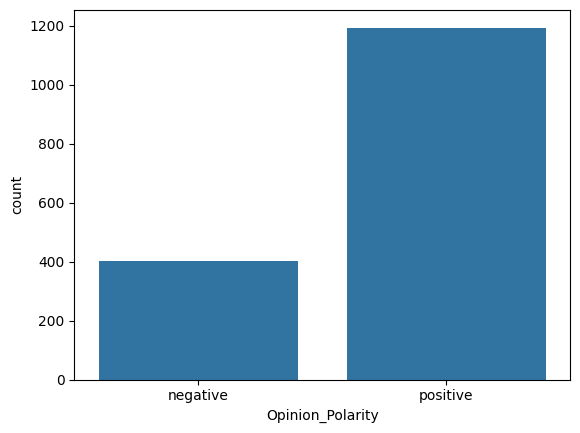

In [28]:
sns.countplot(x = "Opinion_Polarity", data = df)
plt.show()

### Adding dummy negative Opinion reviews in dataset 

In [29]:
temp_df = df.copy()
df_negative = df[df['Opinion_Polarity'] == 'negative']
df = pd.concat([temp_df, df_negative], ignore_index=True) 

### Opinion_Polarity distribution in our dataset

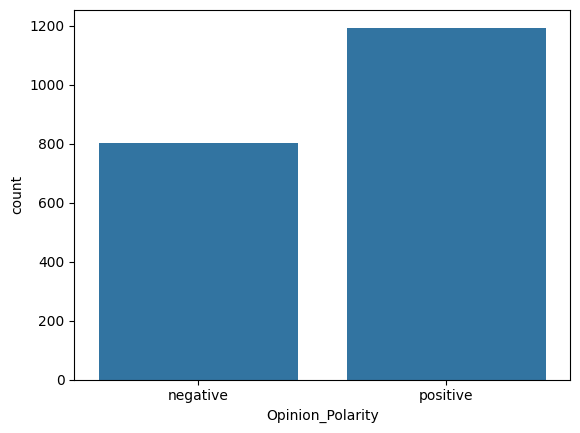

In [30]:
sns.countplot(x = "Opinion_Polarity", data = df)
plt.show()

## Save the preprocessed data to a new CSV file

In [31]:
df.to_csv("../datasets/training_dataset/Preprocessed_Restuarant_Dataset.csv", index=False)